<a href="https://colab.research.google.com/github/ksila01/deployment2/blob/main/POTATO_DISEASE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARIES**

In [1]:
# Loading data Library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Computational Libraries
import os
from PIL import Image
import numpy as np
import random

# Modelling Libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers

# Library to save models
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


# **LOAD THE DATA**

In [2]:
# dataset path
dataset_path = 'Potatoes_with_Augmentation'

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load the dataset using flow_from_directory for potatoes
potato_leaf_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

Found 2400 images belonging to 3 classes.


# **EXPLORATORY DATA ANALYSIS**

### **Class Labels**

In [3]:
# Get the class labels and indices
class_labels = list(potato_leaf_generator.class_indices.keys())
class_indices = potato_leaf_generator.class_indices

print(class_labels)
print(class_indices)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


## **Visualize 3 images per class**

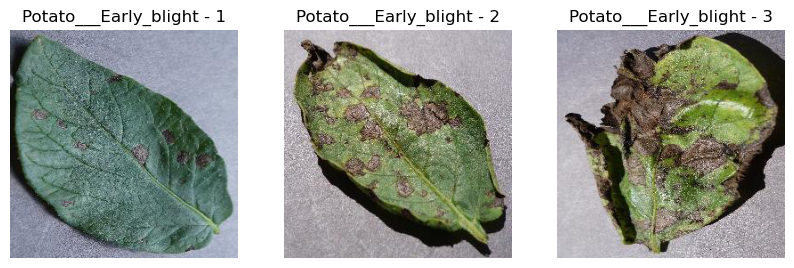

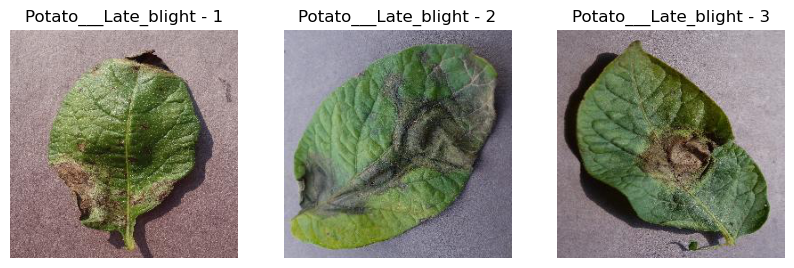

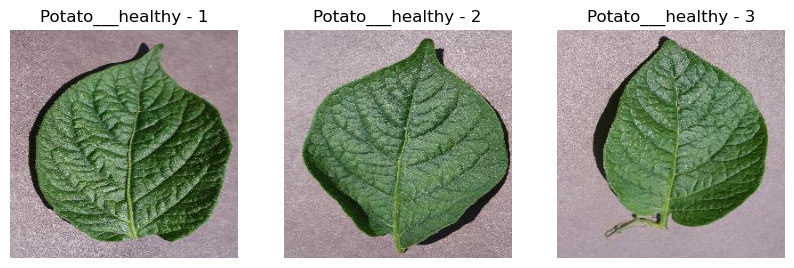

In [4]:
# Function to display images for a given class
def display_images(class_name, num_images=3):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        print(f"Directory not found: {class_path}")
        return
    image_files = os.listdir(class_path)[:num_images]

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(image_files, 1):
        img_path = os.path.join(class_path, image_file)

        # Check if the image file exists
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = Image.open(img_path)

        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f'{class_name} - {i}')
        plt.axis('off')

    plt.show()

for class_label in class_labels:
    display_images(class_label, num_images=3)


## **Image Size Distribution**

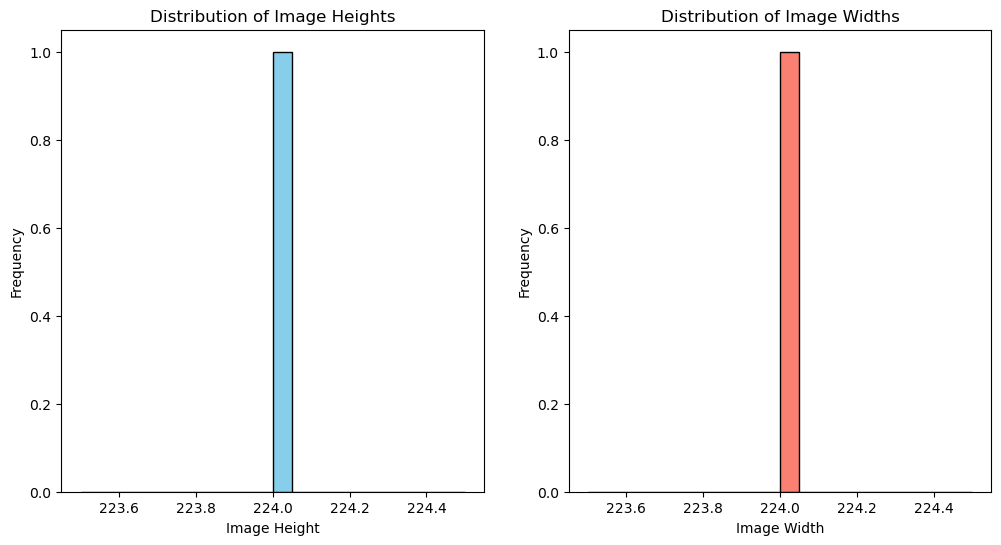

In [5]:
# Image sizes from a few samples
sample_images = potato_leaf_generator.next()[0]
image_heights = sample_images.shape[1]
image_widths = sample_images.shape[2]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(image_heights, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Image Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(image_widths, bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Image Width')
plt.ylabel('Frequency')

plt.show()

Observation:

The potato leaf images in our dataset have consistent dimensions, with the same height and width.

## **Aspect Ratio**

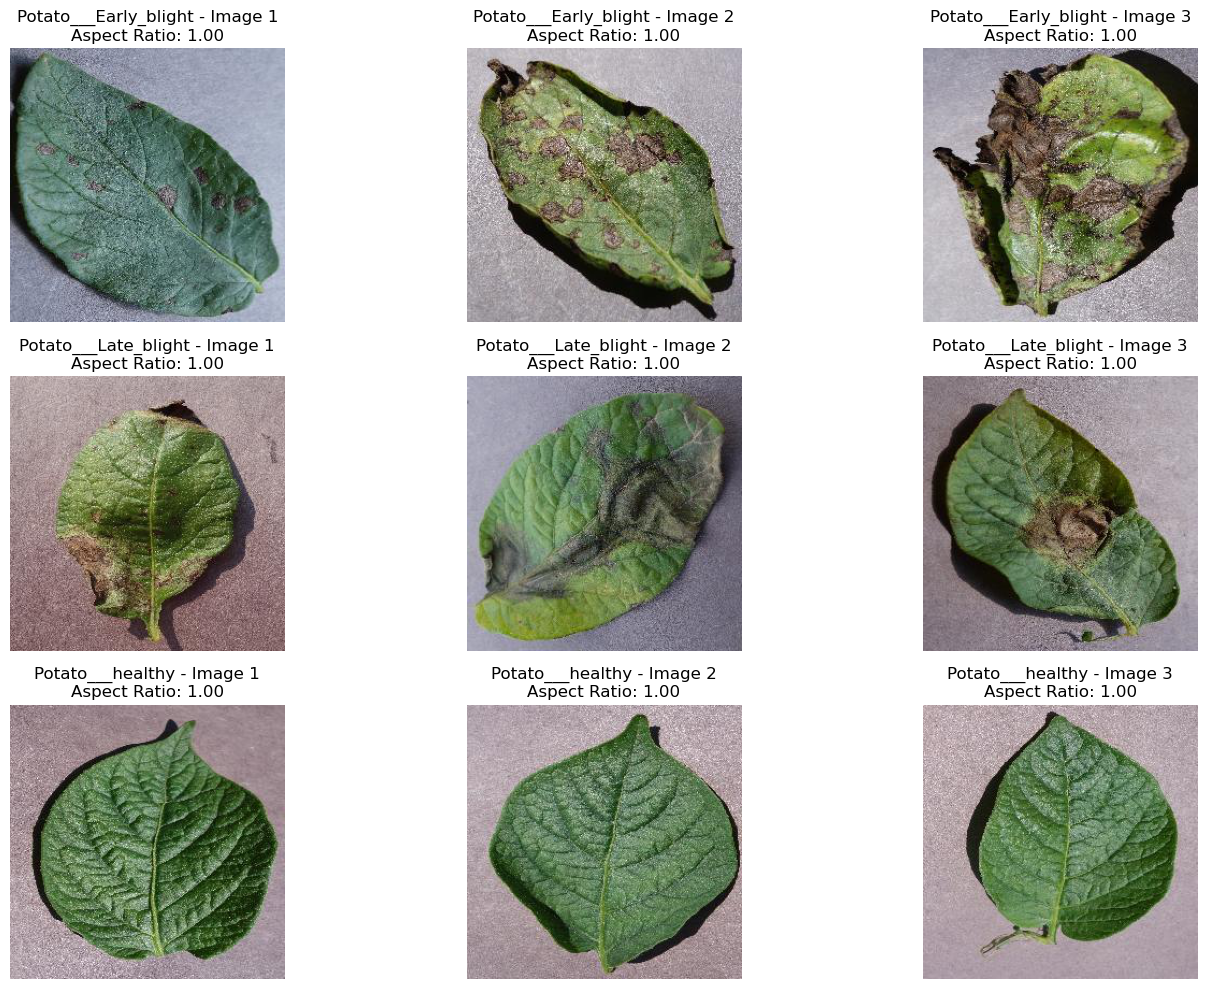

In [6]:
# Function to display aspect ratio distribution for multiple images in each class
def display_aspect_ratio_for_classes(num_images_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_label in enumerate(class_labels):
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)[:num_images_per_class]

        for j, image_file in enumerate(image_files):
            # Load the image and convert it to a numpy array
            img_path = os.path.join(class_path, image_file)
            img = np.array(Image.open(img_path))

            # Calculate aspect ratio
            aspect_ratio = img.shape[0] / img.shape[1]

            # Plot aspect ratio distribution
            plt.subplot(len(class_labels), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)  # Show the image
            plt.title(f'{class_label} - Image {j + 1}\nAspect Ratio: {aspect_ratio:.2f}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_aspect_ratio_for_classes()



Observation:

With an aspect ratio of 1.0, the images have the same height and width. To confirm this further we will check the shape of the whole dataset. There is no need to resize or reshape the images.


## **Colour Distribution of the Images**

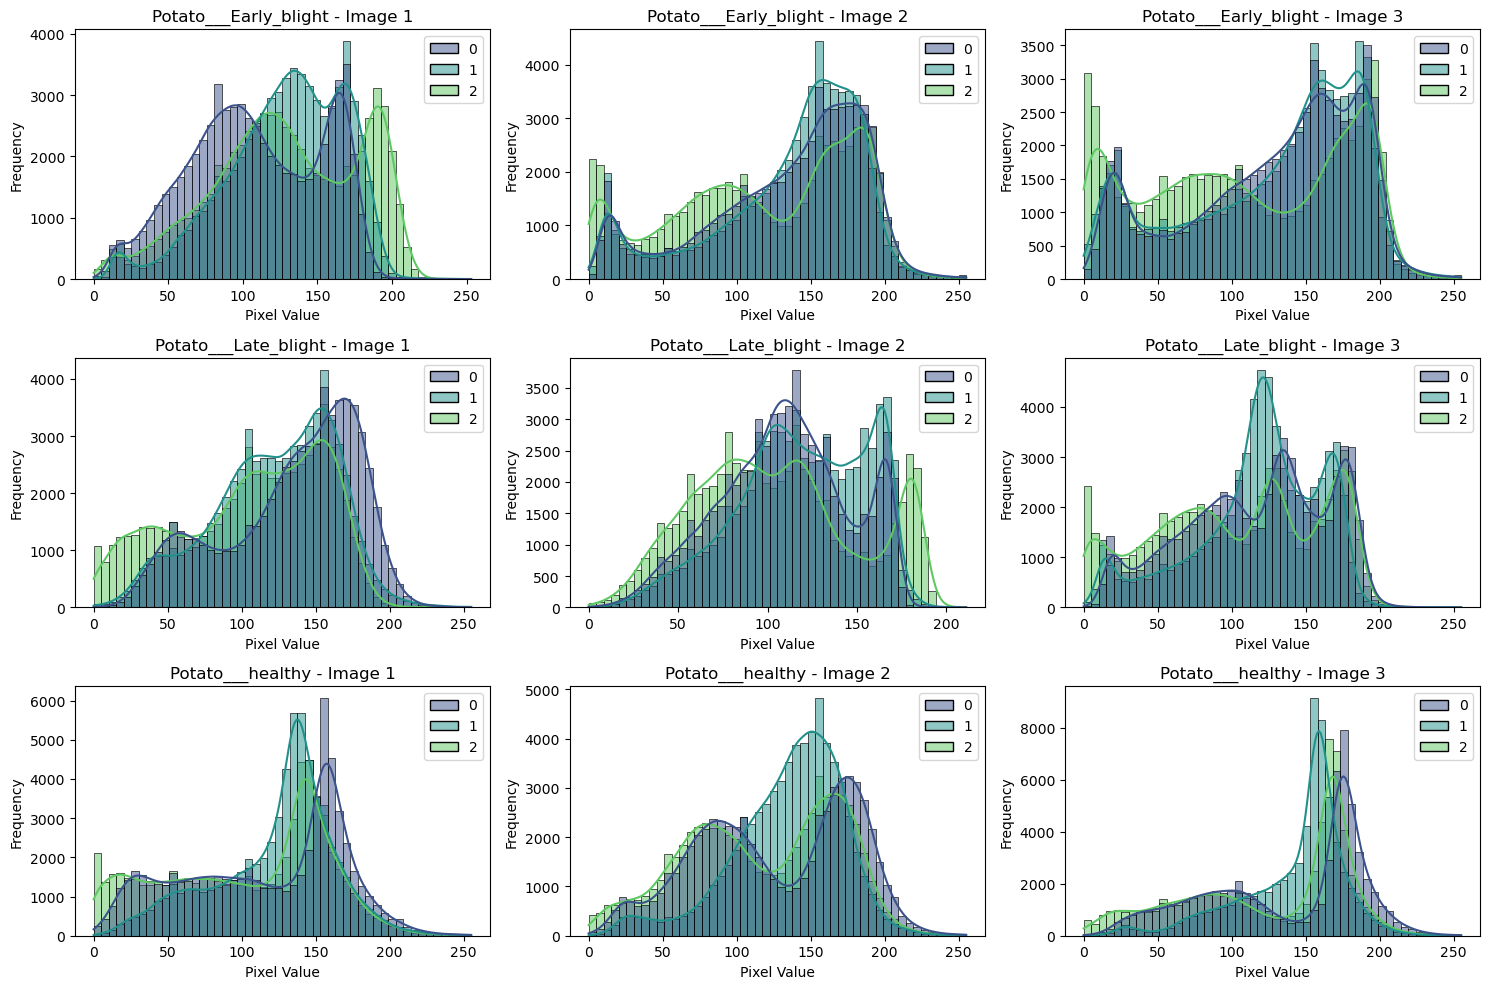

In [7]:
# Function to display color distribution for multiple images in each class
def display_color_distribution_for_classes(num_images_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_label in enumerate(class_labels):
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)[:num_images_per_class]

        for j, image_file in enumerate(image_files):
            # Load the image and convert it to a numpy array
            img_path = os.path.join(class_path, image_file)
            img = np.array(Image.open(img_path))

            # Reshape the image for color distribution
            flattened_image = img.reshape(-1, img.shape[-1])

            # Plot color distribution
            plt.subplot(len(class_labels), num_images_per_class, i * num_images_per_class + j + 1)
            sns.histplot(flattened_image, bins=50, kde=True, palette='viridis')
            plt.title(f'{class_label} - Image {j + 1}')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

display_color_distribution_for_classes()

Observation:

The diverse distributions across different classes suggest variations in color characteristics and patterns unique to each class. The presence of right or left skewness and different peaks indicates the diversity of color compositions within our dataset.

We will analyze the RGB distributions in various images to check if there's a consistent presence of green, yellow, and brown tints as is in our images.




C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


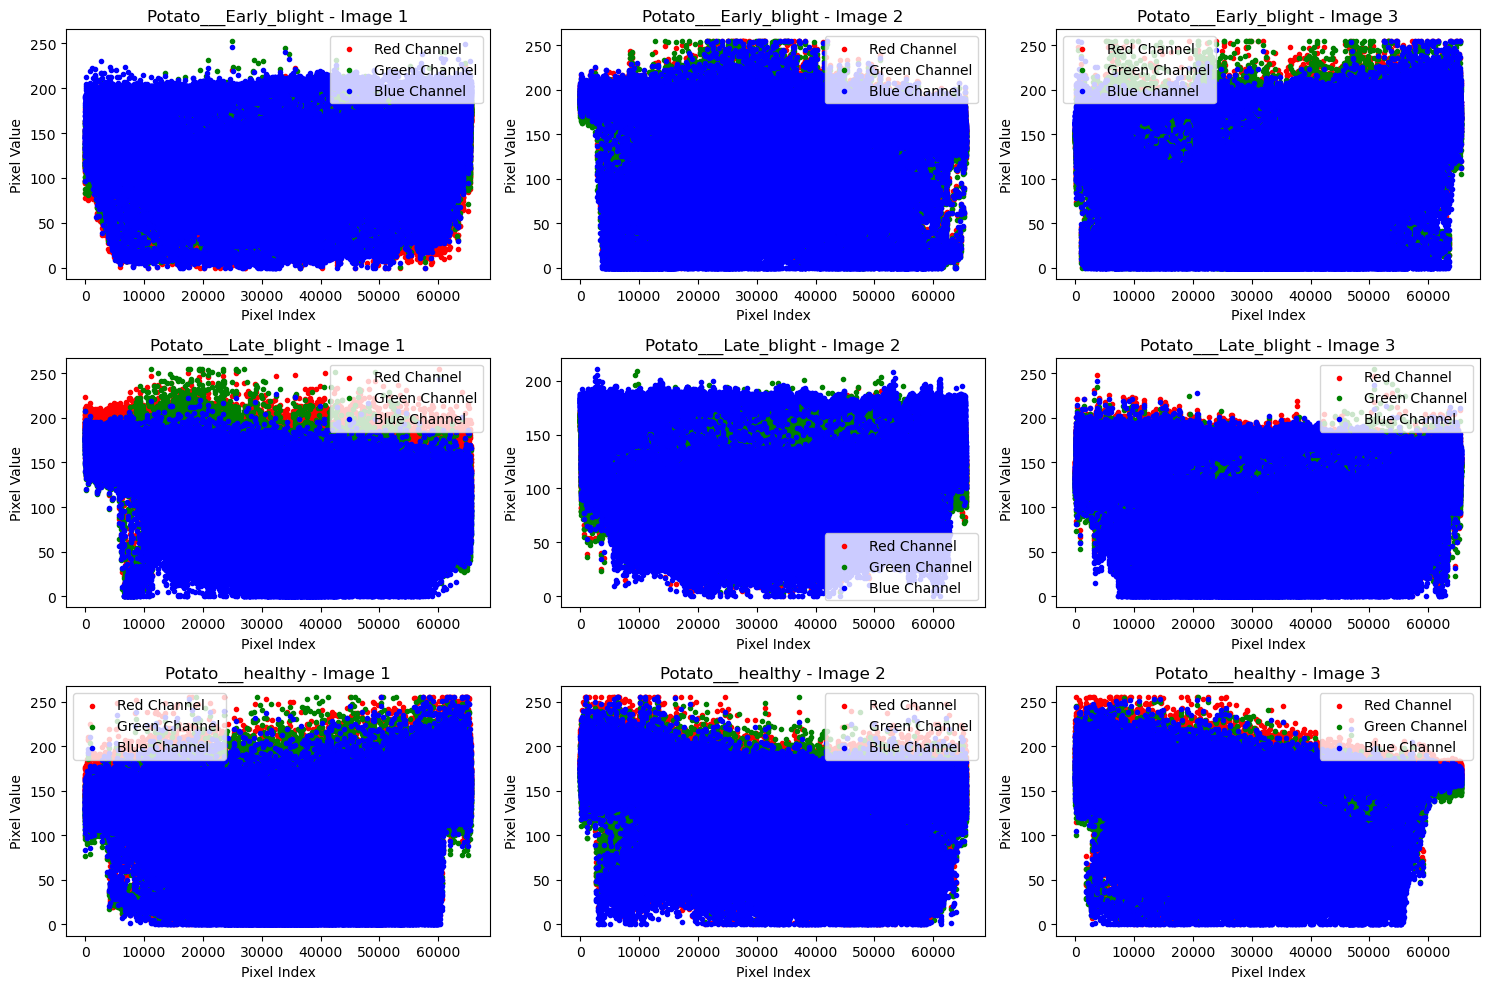

In [8]:
# Function to display RGB distributions for multiple images in each class
def display_rgb_scatter_for_classes(num_images_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_label in enumerate(class_labels):
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)[:num_images_per_class]

        for j, image_file in enumerate(image_files):
            # Load the image and convert it to a numpy array
            img_path = os.path.join(class_path, image_file)
            img = np.array(Image.open(img_path))

            # Get RGB values for each pixel
            red_values = img[:, :, 0].flatten()
            green_values = img[:, :, 1].flatten()
            blue_values = img[:, :, 2].flatten()

            # Plot RGB distributions using scatter plots
            plt.subplot(len(class_labels), num_images_per_class, i * num_images_per_class + j + 1)

            plt.scatter(range(len(red_values)), red_values, color='red', marker='.', label='Red Channel')
            plt.scatter(range(len(green_values)), green_values, color='green', marker='.', label='Green Channel')
            plt.scatter(range(len(blue_values)), blue_values, color='blue', marker='.', label='Blue Channel')

            plt.title(f'{class_label} - Image {j + 1}')
            plt.xlabel('Pixel Index')
            plt.ylabel('Pixel Value')
            plt.legend()

    plt.tight_layout()
    plt.show();

display_rgb_scatter_for_classes()



Observation:

The blue channel dominance aligns with the common color characteristics of green leaves, as chlorophyll, the primary pigment responsible for photosynthesis, absorbs mostly in the blue part of the spectrum.


## **Analyze class distribution**

In [9]:
# Get the count of images for each class
class_counts = potato_leaf_generator.classes
class_labels = potato_leaf_generator.class_indices.keys()

# Create a dictionary mapping class labels to counts
class_counts_dict = {label: count for label, count in zip(class_labels, np.bincount(class_counts))}
class_counts_dict

{'Potato___Early_blight': 800,
 'Potato___Late_blight': 800,
 'Potato___healthy': 800}

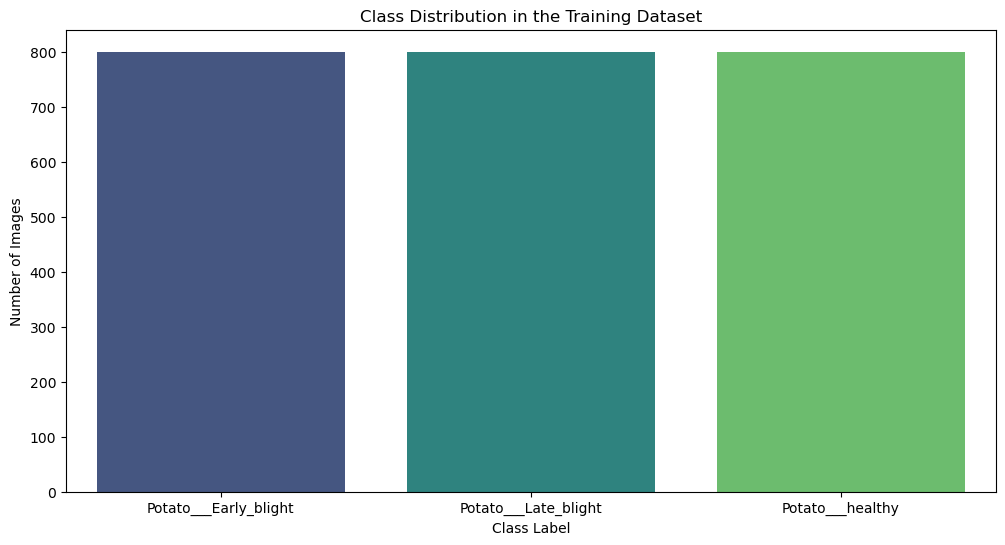

In [10]:
# Visualize the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts_dict.keys()), y=list(class_counts_dict.values()), palette='viridis')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Training Dataset')
plt.xticks(rotation='horizontal')
plt.show()

Observation:

Our dataset has a well-balanced distribution among the classes:

Potato___Early_blight: 800 images
Potato___Late_blight: 832 images
Potato___healthy: 800 images

This balanced representation provides a good foundation for training our model to recognize various aspects of early blight, late blight, and healthy potato leaves.

# **MODEL ARCHITECTURE**

## **Check GPU Availability**

GPU is a stronger processor for image classification models compared to CPU.

In [11]:
# Number of GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## **Train and Validation Split**

In [12]:
# Set batch size and image size
batch_size = 32
image_size = (224, 224)

# Create training data
training_data_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## **Basic Model - CNN**

Our CNN model will use ReLU to introduce non-linearity and capture complex patterns in hidden layers and a Softmax output layer to convert raw scores into class probabilities for multi-class classification.

In [13]:
# CNN model
num_classes = 3

# Generate the model
base_cnn_model = Sequential()
base_cnn_model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
base_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
base_cnn_model.add(Flatten())
base_cnn_model.add(Dense(128, activation='relu'))
base_cnn_model.add(Dense(num_classes, activation='softmax'))


base_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 50468227 (192.52 MB)
Trainable params: 50468227 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [14]:
# Train the model
history = base_cnn_model.fit(
    training_data_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


75/75 [==============================] - 102s 1s/step - loss: 4.0103 - accuracy: 0.7113 - val_loss: 0.2831 - val_accuracy: 0.9000
Epoch 2/10
75/75 [==============================] - 95s 1s/step - loss: 0.1858 - accuracy: 0.9250 - val_loss: 0.1328 - val_accuracy: 0.9650
Epoch 3/10
75/75 [==============================] - 101s 1s/step - loss: 0.1619 - accuracy: 0.9283 - val_loss: 0.2340 - val_accuracy: 0.9000
Epoch 4/10
75/75 [==============================] - 103s 1s/step - loss: 0.1320 - accuracy: 0.9504 - val_loss: 0.1427 - val_accuracy: 0.9383
Epoch 5/10
75/75 [==============================] - 114s 2s/step - loss: 0.1125 - accuracy: 0.9596 - val_loss: 0.0990 - val_accuracy: 0.9650
Epoch 6/10
75/75 [==============================] - 100s 1s/step - loss: 0.0908 - accuracy: 0.9642 - val_loss: 0.2711 - val_accuracy: 0.8950
Epoch 7/10
75/75 [==============================] - 106s 1s/step - loss: 0.1164 - accuracy: 0.9554 - val_loss: 0.1182 - val_accuracy: 0.9533
Epoch 8/10
7

### **Visualize Training Loss and Training Accuracy**

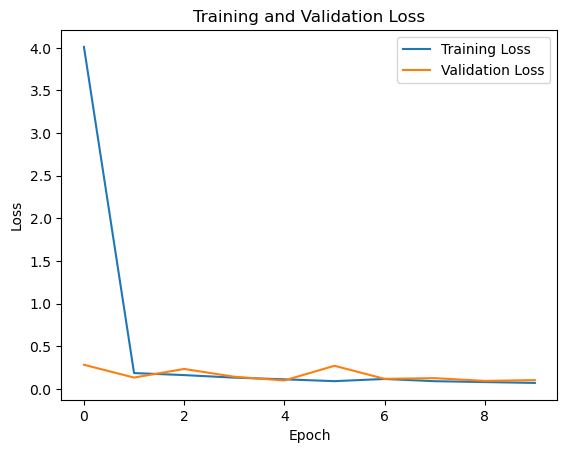

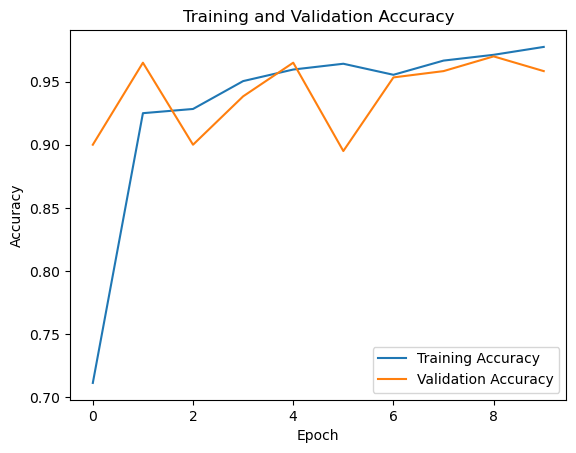

In [15]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

### **Evaluate the Basic CNN model**



In [16]:
# Evaluate the model
evaluation_results = base_cnn_model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(evaluation_results[1] * 100))
print("Validation Loss: {:.4f}".format(evaluation_results[0]))


19/19 [==============================] - 18s 928ms/step - loss: 0.0957 - accuracy: 0.9667
Validation Accuracy: 96.67%
Validation Loss: 0.0957


Observation:

Our CNN achieved 96.38% validation accuracy in classifying potato leaf diseases, but insights from the Confusion Matrix and Classification Report reveal variations in performance across classes.

We will leverage Ensembling using GoogleNet's Inception architecture. These steps aim to refine the model's ability to distinguish between healthy and diseased potato leaves.













## **GoogleNet's Inception Model**


This method ensures efficient feature extraction with its inception modules, reducing parameters for computational efficiency. Its multi-pathway design captures diverse features, providing a broader receptive field and enabling effective representation learning.

By augmenting this base with a Global Average Pooling layer and a Dense layer employing softmax activation for classification, the model adapts its knowledge to the task of identifying potato leaf diseases.

An EarlyStopping callback is implemented to curb overfitting and ensure optimal generalization during the training process.

### **Define EarlyStopping callback**

In [17]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [18]:
# Create InceptionV3 model
base_inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_inception_model.layers:
    layer.trainable = False

# Create InceptionV3 base with custom layers
inception_model = Sequential([
    base_inception_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22065443 (84.17 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [19]:
# Train the model
history_inception = inception_model.fit(
    training_data_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10
75/75 [==============================] - 181s 2s/step - loss: 0.4024 - accuracy: 0.8396 - val_loss: 0.3074 - val_accuracy: 0.8700
Epoch 2/10
75/75 [==============================] - 163s 2s/step - loss: 0.2078 - accuracy: 0.9246 - val_loss: 0.2574 - val_accuracy: 0.8933
Epoch 3/10
75/75 [==============================] - 166s 2s/step - loss: 0.1604 - accuracy: 0.9396 - val_loss: 0.1885 - val_accuracy: 0.9383
Epoch 4/10
75/75 [==============================] - 166s 2s/step - loss: 0.1701 - accuracy: 0.9375 - val_loss: 0.1697 - val_accuracy: 0.9433
Epoch 5/10
75/75 [==============================] - 162s 2s/step - loss: 0.1215 - accuracy: 0.9529 - val_loss: 0.1799 - val_accuracy: 0.9250
Epoch 6/10
75/75 [==============================] - 166s 2s/step - loss: 0.0911 - accuracy: 0.9679 - val_loss: 0.1707 - val_accuracy: 0.9450
Epoch 7/10
75/75 [==============================] - 163s 2s/step - loss: 0.1165 - accuracy: 0.9529 - val_loss: 0.1821 - val_accuracy: 0.9367
Epoch 8/10
75

### **Visualize Training Loss and Training Accuracy**

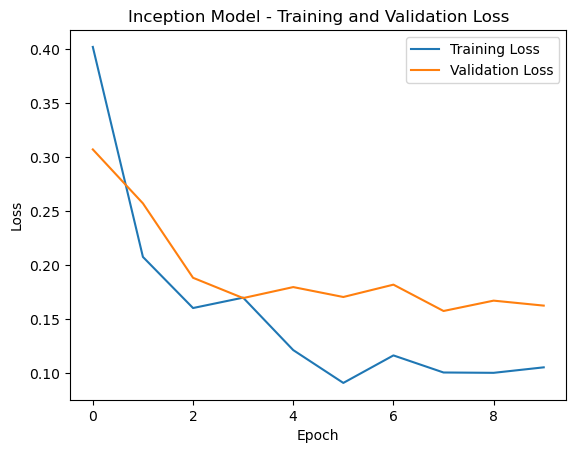

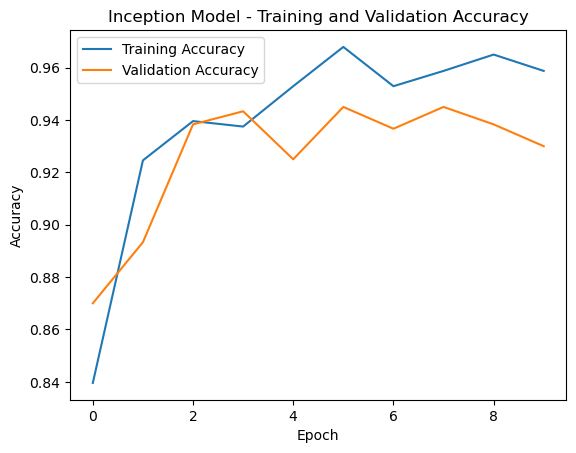

In [20]:
# Plot training loss
plt.plot(history_inception.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('Inception Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('Inception Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **Evaluate the Inception model**

In [21]:
# Evaluate the model
evaluation_results_inception = inception_model.evaluate(validation_generator)

print("Validation Accuracy: {:.2f}%".format(evaluation_results_inception[1] * 100))
print("Validation Loss: {:.4f}".format(evaluation_results_inception[0]))

19/19 [==============================] - 34s 2s/step - loss: 0.1293 - accuracy: 0.9583
Validation Accuracy: 95.83%
Validation Loss: 0.1293


## **Save CNN and Inception models**

Prior to ensembling we need to save both models for use.

In [22]:
# Save the models
base_cnn_model.save('base_cnn_model.h5')
inception_model.save('inception_model.h5')

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Load the saved models
base_cnn_model = load_model('base_cnn_model.h5')
inception_model = load_model('inception_model.h5')

## **Ensembled - CNN and Inception Models**

In [24]:
# Create input layer
input_layer = Input(shape=((224, 224, 3)))

# Get predictions from the base CNN model
base_cnn_predictions = base_cnn_model(input_layer)

# Get predictions from the Inception model
inception_predictions = inception_model(input_layer)

# Concatenate the predictions
concatenated_predictions = Concatenate()([base_cnn_predictions, inception_predictions])

# Add a Dense layer for final prediction
output_layer = Dense(num_classes, activation='softmax')(concatenated_predictions)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=output_layer)


ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 3)                    5046822   ['input_2[0][0]']             
                                                          7                                       
                                                                                                  
 sequential_1 (Sequential)   (None, 3)                    2206544   ['input_2[0][0]']             
                                                          3                                       
                                                                                              

In [25]:
# Train the ensemble model
history_ensemble = ensemble_model.fit(
    training_data_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10
75/75 [==============================] - 256s 3s/step - loss: 1.0957 - accuracy: 0.3246 - val_loss: 1.0413 - val_accuracy: 0.3333
Epoch 2/10
75/75 [==============================] - 230s 3s/step - loss: 1.0153 - accuracy: 0.5250 - val_loss: 1.0043 - val_accuracy: 0.5867
Epoch 3/10
75/75 [==============================] - 222s 3s/step - loss: 0.9682 - accuracy: 0.6296 - val_loss: 0.9600 - val_accuracy: 0.5650
Epoch 4/10
75/75 [==============================] - 225s 3s/step - loss: 0.9209 - accuracy: 0.6408 - val_loss: 0.9078 - val_accuracy: 0.6333
Epoch 5/10
75/75 [==============================] - 223s 3s/step - loss: 0.8793 - accuracy: 0.6433 - val_loss: 0.8578 - val_accuracy: 0.6500
Epoch 6/10
75/75 [==============================] - 221s 3s/step - loss: 0.8407 - accuracy: 0.6629 - val_loss: 0.8220 - val_accuracy: 0.6867
Epoch 7/10
75/75 [==============================] - 218s 3s/step - loss: 0.8099 - accuracy: 0.6533 - val_loss: 0.8120 - val_accuracy: 0.6300
Epoch 8/10
75

### **Visualize Training Loss and Training Accuracy**

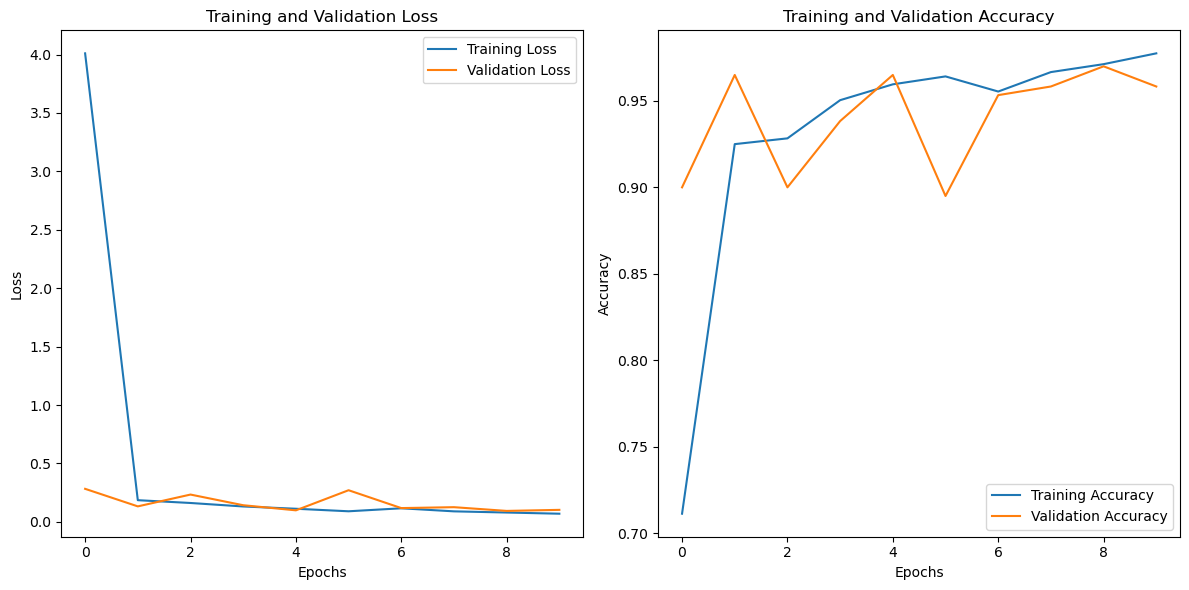

In [26]:
# Access the training history
history_ensemble = history.history

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_ensemble['loss'], label='Training Loss')
plt.plot(history_ensemble['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history_ensemble['accuracy'], label='Training Accuracy')
plt.plot(history_ensemble['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### **Evaluate the ensembled models**

In [27]:
# Evaluate the ensemble model
evaluation_results_ensemble = ensemble_model.evaluate(validation_generator)

print("Ensemble Model Accuracy: {:.2f}%".format(evaluation_results_ensemble[1] * 100))
print("Ensemble Model Loss: {:.4f}".format(evaluation_results_ensemble[0]))


19/19 [==============================] - 37s 2s/step - loss: 0.7257 - accuracy: 0.6650
Ensemble Model Accuracy: 66.50%
Ensemble Model Loss: 0.7257


## **TEST THE MODELS ON UNSEEN DATA**

## **Load and resize the dataset**

In [28]:
# Create an ImageDataGenerator for unseen data
unseen_datagen = ImageDataGenerator(rescale=1./255)

# Create an unseen data generator
unseen_generator = unseen_datagen.flow_from_directory(
    'test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False )

Found 4072 images belonging to 3 classes.


## **Evaluation On Performance**

### **Define True Labels**

In [29]:
# Get true labels
true_labels = unseen_generator.classes
true_labels

array([0, 0, 0, ..., 2, 2, 2])

### **Base CNN Model**

In [30]:
# Evaluate the Base CNN model on the unseen data
evaluation_results_base_cnn = base_cnn_model.evaluate(unseen_generator)
print("Base CNN Model Unseen Data Accuracy: {:.2f}%".format(evaluation_results_base_cnn[1] * 100))
print("Base CNN Model Unseen Data Loss: {:.4f}".format(evaluation_results_base_cnn[0]))

# Predict classes for unseen data with Base CNN model
predictions_base_cnn = base_cnn_model.predict(unseen_generator)
predicted_classes_base_cnn = np.argmax(predictions_base_cnn, axis=1)

# Generate confusion matrix and classification report for Base CNN model
conf_matrix_base_cnn = confusion_matrix(true_labels, predicted_classes_base_cnn)
class_report_base_cnn = classification_report(true_labels, predicted_classes_base_cnn)

print("Base CNN Model Confusion Matrix:\n", conf_matrix_base_cnn)
print("\nBase CNN Model Classification Report:\n", class_report_base_cnn)

128/128 [==============================] - 114s 892ms/step - loss: 14.8329 - accuracy: 0.2178
Base CNN Model Unseen Data Accuracy: 21.78%
Base CNN Model Unseen Data Loss: 14.8329
128/128 [==============================] - 31s 226ms/step
Base CNN Model Confusion Matrix:
 [[   0 1627    1]
 [   0  883  137]
 [   0 1420    4]]

Base CNN Model Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1628
           1       0.22      0.87      0.36      1020
           2       0.03      0.00      0.01      1424

    accuracy                           0.22      4072
   macro avg       0.08      0.29      0.12      4072
weighted avg       0.07      0.22      0.09      4072



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Inception Model**

In [31]:
# Evaluate the Inception model on the unseen data
evaluation_results_inception = inception_model.evaluate(unseen_generator)
print("Inception Model Unseen Data Accuracy: {:.2f}%".format(evaluation_results_inception[1] * 100))
print("Inception Model Unseen Data Loss: {:.4f}".format(evaluation_results_inception[0]))

# Predict classes for unseen data with Inception model
predictions_inception = inception_model.predict(unseen_generator)
predicted_classes_inception = np.argmax(predictions_inception, axis=1)

# Generate and display confusion matrix and classification report for Inception model
conf_matrix_inception = confusion_matrix(true_labels, predicted_classes_inception)
class_report_inception = classification_report(true_labels, predicted_classes_inception)

print("Inception Model Confusion Matrix:\n", conf_matrix_inception)
print("\nInception Model Classification Report:\n", class_report_inception)

128/128 [==============================] - 190s 1s/step - loss: 21.9407 - accuracy: 0.3998
Inception Model Unseen Data Accuracy: 39.98%
Inception Model Unseen Data Loss: 21.9407
128/128 [==============================] - 189s 1s/step
Inception Model Confusion Matrix:
 [[1628    0    0]
 [1020    0    0]
 [1424    0    0]]

Inception Model Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1628
           1       0.00      0.00      0.00      1020
           2       0.00      0.00      0.00      1424

    accuracy                           0.40      4072
   macro avg       0.13      0.33      0.19      4072
weighted avg       0.16      0.40      0.23      4072



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Ensemble Model**

In [32]:
# Evaluate the Ensemble model on the unseen data
evaluation_results_ensemble = ensemble_model.evaluate(unseen_generator)
print("Ensemble Model Unseen Data Accuracy: {:.2f}%".format(evaluation_results_ensemble[1] * 100))
print("Ensemble Model Unseen Data Loss: {:.4f}".format(evaluation_results_ensemble[0]))

# Predict classes for unseen data with Ensemble model
predictions_ensemble = ensemble_model.predict(unseen_generator)
predicted_classes_ensemble = np.argmax(predictions_ensemble, axis=1)

# Generate confusion matrix and classification report for Ensemble model
conf_matrix_ensemble = confusion_matrix(true_labels, predicted_classes_ensemble)
class_report_ensemble = classification_report(true_labels, predicted_classes_ensemble)

print("Ensemble Model Confusion Matrix:\n", conf_matrix_ensemble)
print("\nEnsemble Model Classification Report:\n", class_report_ensemble)

128/128 [==============================] - 199s 2s/step - loss: 1.2439 - accuracy: 0.4062
Ensemble Model Unseen Data Accuracy: 40.62%
Ensemble Model Unseen Data Loss: 1.2439
128/128 [==============================] - 195s 1s/step
Ensemble Model Confusion Matrix:
 [[1623    2    3]
 [ 856   27  137]
 [1413    7    4]]

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.42      1.00      0.59      1628
           1       0.75      0.03      0.05      1020
           2       0.03      0.00      0.01      1424

    accuracy                           0.41      4072
   macro avg       0.40      0.34      0.21      4072
weighted avg       0.36      0.41      0.25      4072



# **SAVE THE MODELS**

In [33]:
# Save the models
base_cnn_model.save('base_cnn_model.h5')
inception_model.save('inception_model.h5')
ensemble_model.save('ensemble_model.h5')

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **CONCLUSION**



Conclusion:

* 1. Base CNN Model:

Achieved a high validation accuracy of 96.67% in classifying potato leaf diseases.
Shows promising performance but exhibits variations in accuracy across different disease classes.
* Recommendations:
Investigate and address variations in class-wise performance.
Consider additional data augmentation techniques to improve generalization.
* 2. Inception Model:

Achieved a validation accuracy of 95.83%, providing an alternative architecture for feature extraction.
Slightly lower accuracy compared to the base CNN model.
* Recommendations:
Fine-tune the Inception model to potentially improve accuracy.
Analyze misclassifications to understand specific challenges in disease prediction.
* 3. Ensemble Model:

* Exhibits a significant drop in accuracy to 66.50%, indicating challenges in combining the strengths of the base CNN and Inception models.
* Ensemble may not have effectively leveraged the individual models for improved performance.
### Recommendations:
* Analyze and address issues causing the drop in accuracy.
* Reevaluate the ensembling approach, ensuring compatibility and complementary strengths of the individual models.
### General Suggestions for Potato Leaf Disease Prediction:

* Investigate and address variations in performance across different disease classes in all models.
* Explore fine-tuning options, especially for the Inception model, to enhance accuracy in disease classification.
* Consider additional features or data sources that may improve the models' ability to distinguish between healthy and diseased potato leaves.
* Regularly update and fine-tune models based on new data or insights to adapt to changing disease patterns.
* Collaborate with domain experts to gain insights into specific challenges in potato leaf disease identification.
* Implement measures to ensure a consistent and well-balanced dataset for training and validation.
* Experiment with transfer learning techniques to leverage pre-trained models for improved performance.
* Monitor for overfitting and apply regularization techniques as needed.
* Experiment with learning rate schedules during training to optimize model convergence.
* Continued refinement and analysis, guided by insights from misclassifications and domain knowledge, are crucial for enhancing the accuracy and reliability of potato leaf disease predictions.



## Future Recommendations to Address Non-Potato Image Misclassifications:

#### Diverse Negative Class Data Augmentation:

* Enhance the negative class representation in the training data by incorporating diverse non-potato images. Augment the dataset with images of different objects, backgrounds, and lighting conditions to improve the model's ability to discriminate between potatoes and non-potato objects.
#### Out-of-Distribution Detection:

* Implement an out-of-distribution detection mechanism to identify instances where the model is uncertain about the classification. Utilize techniques such as confidence score thresholds or uncertainty estimates to flag predictions with lower confidence. This will enable a post-processing step to filter out potential non-potato images, reducing false positives and enhancing the model's specificity.
#### Future Refinement Rationale

* Diversifying the negative class data allows the model to learn more robust features specific to potatoes, reducing the likelihood of misclassifying non-potato images.
* Out-of-distribution detection adds an additional layer of confidence assessment, enabling the system to handle uncertainty and flag predictions that may be less reliable. This paves the way for continuous refinement based on user feedback and improved model updates over time.

## Deployment
Considering the provided information, the Base CNN Model is recommended for deployment using the Streamlit app. Here's the rationale:

#### Rationale:
* The base CNN model achieved the highest validation accuracy among the models, with an accuracy of 96.67%. This indicates that the model has demonstrated strong performance in classifying potato leaf diseases during training and validation.
* The base CNN architecture provides a solid foundation for image classification tasks. It includes convolutional layers for feature extraction, pooling layers for down-sampling, and fully connected layers for classification, making it well-suited for the task of identifying patterns in potato leaf images.
* The base CNN model is relatively simpler compared to the ensemble model. Streamlit apps benefit from simplicity to ensure efficient deployment and responsiveness, making the base CNN model a suitable choice for a straightforward deployment scenario.
* Deploying a model with high accuracy provides a positive user experience, instilling confidence in the reliability of the application for predicting potato leaf diseases.